# Advanced DataFrame handling

## Aligning countries number of cases

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('time_series_covid19_confirmed_global.csv') # this is pandas function

In [4]:
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,299,349,367,423,444,484,521,555,607,665
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,333,361,377,383,400,409,416,433,446,467
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,466,501,525,545,564,583,601,601,638,646
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,10,14,16,17,19,19,19,19,19,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Saint Pierre and Miquelon,France,46.885200,-56.315900,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1
260,NaN,South Sudan,6.877000,31.307000,0,0,0,0,0,0,...,0,1,1,2,2,3,4,4,4,4
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,0,4,4,4,4,4,4,4,6,6
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,0,0,4,4,4,4,4,4,4,4


In [46]:
longdf = df.rename(columns={'Country/Region':'country'}).set_index('country', drop=True)
# i like to use column names that are all lowercase and that can be identifiers (i.e. variable names)
# see here: https://www.programiz.com/python-programming/keywords-identifier
print('set new index:\n', longdf.head())

longdf = longdf.drop(columns=['Lat', 'Long', 'Province/State'])
longdf.columns.name = 'dates'  # all the columns correspond to dates now, so let's give columns a name
# this column name will show up later after stacking
print('drop unnecessary columns:\n', longdf.head())

longdf = longdf.stack()
# let's give this new series a name
longdf.name = 'cases'
# this series name will show up later after reseting index
print('stack all columns -> creates pd.Series:\n', longdf.head())

longdf = longdf.reset_index()
print('reset index -> creates pd.DataFrame in this case:\n', longdf.head())

print('check the datatypes in each column:\n', longdf.dtypes)
# dates is an object and not a pandas datetime!!! -> we want to have pandas datetime
# luckily pandas has a nice functionality to infer datetimes
# let's reassign date
# and we want dates in units of days
longdf['dates'] = pd.to_datetime(longdf['dates']).astype('datetime64[D]')
print('check the datatypes in each column again:\n', longdf.dtypes)


set new index:
             Province/State      Lat     Long  1/22/20  1/23/20  1/24/20  \
country                                                                   
Afghanistan            NaN  33.0000  65.0000        0        0        0   
Albania                NaN  41.1533  20.1683        0        0        0   
Algeria                NaN  28.0339   1.6596        0        0        0   
Andorra                NaN  42.5063   1.5218        0        0        0   
Angola                 NaN -11.2027  17.8739        0        0        0   

             1/25/20  1/26/20  1/27/20  1/28/20  ...  4/4/20  4/5/20  4/6/20  \
country                                          ...                           
Afghanistan        0        0        0        0  ...     299     349     367   
Albania            0        0        0        0  ...     333     361     377   
Algeria            0        0        0        0  ...    1251    1320    1423   
Andorra            0        0        0        0  ...     4

In [51]:
# this is a very short example of how to use groupby 
# (there are many options of how to use it and what it can spit out, please look at the doc)
# let's align to the day of xth case
no_cases_exceeds = 10

def align_dates(df):
    # groupby will throw the dataframe at you with each groupby iteration for one country in this case
    # take the earliest date where cases exceeds a certain number
    min_date = (df['dates'][df['cases'] > no_cases_exceeds]).min()
    # subtract min_date to get alignment to no_cases_exceeds
    # assign this to a new column
    # and we just care about days with use the timedelta days attribute
    df['aligned_days'] = (df['dates'] - min_date).astype('timedelta64[D]')
    return df

# we get a new longdf with the an additional column called aligned_days
new_longdf = longdf.groupby('country').apply(align_dates)
print(new_longdf.head())

       country      dates  cases  aligned_days
0  Afghanistan 2020-01-22      0         -52.0
1  Afghanistan 2020-01-23      0         -51.0
2  Afghanistan 2020-01-24      0         -50.0
3  Afghanistan 2020-01-25      0         -49.0
4  Afghanistan 2020-01-26      0         -48.0


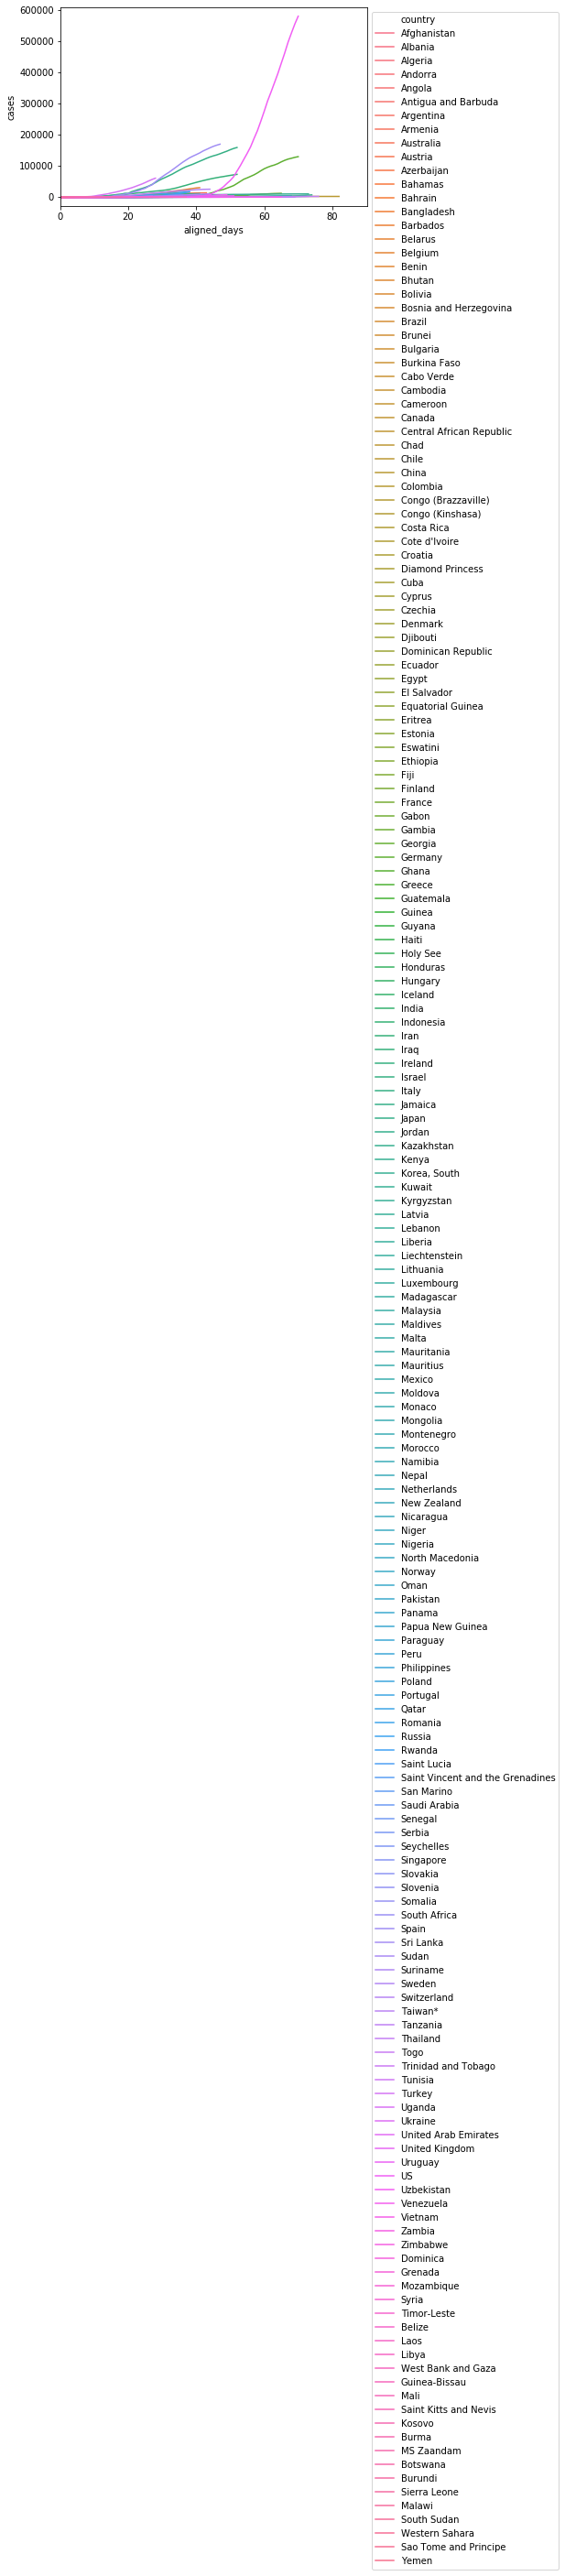

In [56]:
# now we can use seaborn simply to plot, seaborn loves this format
# since the legend is big there is also we can try to restrict to specific countries -> see below

ax = sns.lineplot(
    data=new_longdf, 
    x='aligned_days', 
    y='cases', 
    hue='country', 
    ci=None, 
)

xlims = ax.get_xlim()
ax.set_xlim(0, xlims[1])
# this anchors the legend to the side
ax.legend(bbox_to_anchor=(1,1))

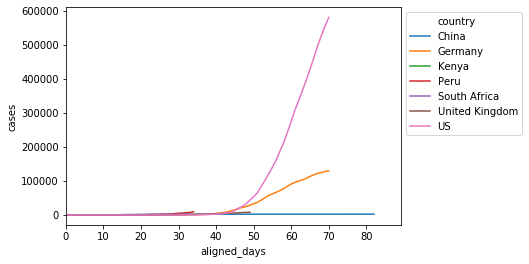

In [57]:
ax = sns.lineplot(
    data=new_longdf[
        new_longdf['country'].isin([
            'US', 'United Kingdom', 
            'Kenya', 'South Africa', 
            'Germany', 'Peru', 
            'China', 'South Korea'
        ])
    ], 
    x='aligned_days', 
    y='cases', 
    hue='country', 
    ci=None, 
)

xlims = ax.get_xlim()
ax.set_xlim(0, xlims[1])
# this anchors the legend to the side
ax.legend(bbox_to_anchor=(1,1))

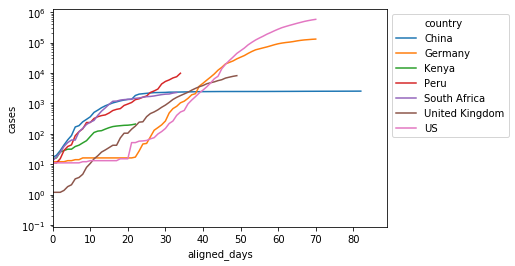

In [58]:
# what about log scale
ax = sns.lineplot(
    data=new_longdf[
        new_longdf['country'].isin([
            'US', 'United Kingdom', 
            'Kenya', 'South Africa', 
            'Germany', 'Peru', 
            'China', 'South Korea'
        ])
    ], 
    x='aligned_days', 
    y='cases', 
    hue='country', 
    ci=None, 
)

xlims = ax.get_xlim()
ax.set_xlim(0, xlims[1])
# this anchors the legend to the side
ax.legend(bbox_to_anchor=(1,1))
ax.set_yscale('log')

In [ ]:
# we could also group countries into regions (by adding a region column) and use 
# sns.FacetGrid to plot multiple of these plots with just a couple lines. 
# 